# Preprocessing Data -  Renaming Training Image Files with Unique Numbering

## Functionality Overview
This script performs two main tasks related to organizing and renaming image files in a training dataset obtained from The MVTec anomaly detection dataset (MVTec AD) https://www.mvtec.com/company/research/datasets/mvtec-ad:

1. **Counting Files in Training Image Directories**:
   - The script iterates through a set of directories that categorize training images (e.g., `broken_large`, `broken_small`, etc.).
   - It counts the total number of files in each directory using the `count_files` function.
   - The total count of files across all training directories is displayed.

2. **Renaming Image Files for Unique Identification**:
   - The script processes image files in a separate `bottle/test` directory for each category.
   - Files are renamed with a unique identifier in the format: `<category_name>_<index>.jpg`.
   - For example, the file `image1.jpg` in the `broken_large` category would be renamed to `broken_large_0.jpg`.

---

## Code Details

### **`count_files(directory)` Function**
- Iterates through all files in a given directory (including subdirectories).
- Returns the total count of files.

### **Training Image Count**
- Uses the `count_files` function to count the number of training images in each of the following directories:
  - `broken_large`
  - `broken_small`
  - `contamination`
  - `good`
- Prints the file count for each category and the total count of training images.

### **File Renaming Logic**
- Iterates through the directories in the `bottle/test` path.
- Renames each file in the directory with a unique name based on its category and index (e.g., `broken_large_0.jpg`).
- The files are renamed to correspond to their specific class, `good, broken small, broken large, contamination, good`, 

---

In [1]:
## trying to rename the training image files to have unique numbering
import os

def count_files(directory):
    file_ct = 0
    for _, _, files in os.walk(directory):
        file_ct += len(files)
    return file_ct

training_img_dirs = ['broken_large', 'broken_small', 'contamination', 'good']

total_train_file_count = 0

for img_dir in training_img_dirs:
    full_path = os.path.join('bottle/train', img_dir)
    file_ct = count_files(full_path)
    print(f'{img_dir} has {file_ct} files')

    total_train_file_count += file_ct

print(f'Total training files: {total_train_file_count}')


for i in range(len(training_img_dirs)):
    img_dir = training_img_dirs[i]
    full_path = os.path.join('bottle/test', img_dir)
    for j, file in enumerate(os.listdir(full_path)):
        new_name = f'{img_dir}_{j}.jpg'
        os.rename(os.path.join(full_path, file), os.path.join(full_path, new_name))
        print(f'{file} -> {new_name}')

    
  


broken_large has 0 files
broken_small has 0 files
contamination has 0 files
good has 0 files
Total training files: 0


FileNotFoundError: [Errno 2] No such file or directory: 'bottle/test/broken_large'

# Preprocessing Step for Pytorch CNN: Creating JSON Annotations for DataLoader (Pytorch)

## Functionality Overview
This code block generates JSON annotation files to map image filenames to their respective labels to use in the DataLoader Class provided by PyTorch. The annotations are created for both the training and testing datasets because training and testing the model requires separate DataLoaders for the respective datasets.

The images are saved containing the class name `i.e broken small` so that the class name for the file can easily be identified. 

---

## Code Details

### **`create_json_labels(directory, output_file)` Function**
This function is responsible for generating JSON files containing image-to-label mappings.

#### Steps:
1. **Remove Existing Annotation File**:
   - If the specified output JSON file already exists, it is deleted to ensure a fresh start.

2. **Initialize Label Mapping**:
   - A dictionary, `label_img_mapping`, is created to store the mapping between filenames and their corresponding labels.

3. **Traverse the Dataset Directory**:
   - Iterates through all files in the specified `directory` under the `bottle/` directory.
   - For each file, checks its name to determine its label:
     - Files containing `"good"` are labeled as `"good"`.
     - Files containing `"broken_large"` are labeled as `"broken_large"`.
     - Files containing `"broken_small"` are labeled as `"broken_small"`.
     - Files containing `"contamination"` are labeled as `"contamination"`.

4. **Write JSON Output**:
   - Saves the `label_img_mapping` dictionary to the specified `output_file` in JSON format, with indented formatting for readability.

---


In [13]:
import os
import json

## Need to create the json file for the DataLoader

def create_json_labels(directory, output_file):
    ## remove an existing annotation file.
    if os.path.exists(output_file):
        os.remove(output_file)

    ## Created from the ground truth folder
    ## Key - filename (i.e img)
    label_img_mapping = {}
    dir = os.path.join('bottle', directory)
    for root, dirs, files in os.walk(dir):
        
        for file in files:
            if 'good' in file:
                label_img_mapping[file] = 'good'
            elif 'broken_large' in file:
                label_img_mapping[file] = 'broken_large'
            elif 'broken_small' in file:
                label_img_mapping[file] = 'broken_small'
            elif 'contamination' in file:
                label_img_mapping[file] = 'contamination'

    with open(output_file, 'w') as f:
        json.dump(label_img_mapping, f, indent=4)


## Create the annotations for the training dataset - broken_large, broken_small, contamination, good
create_json_labels('train', 'train_annotations.json')            

## Create the annotations for the test dataset - good
create_json_labels('test', 'test_annotations.json')


# PyTorch Preparation: Custom Dataset and DataLoader for Bottle Classification

## Functionality Overview
This code defines a custom PyTorch dataset class for loading and preprocessing images of bottles along with their labels. It utilizes the `torch.utils.data.Dataset` interface and integrates data augmentation using `torchvision.transforms`. A DataLoader is used to batch and shuffle the dataset for training.

---

## Code Details

### **`CustomBottleDataset` Class**
A custom dataset class inheriting from PyTorch's `Dataset` interface.

#### **Initialization (`__init__`)**:
- **Parameters**:
  - `data_directory`: The directory where image files are stored.
  - `labels_path`: Path to the JSON file containing image-label mappings.
  - `transform`: Optional data transformations to apply to the images (default is `None`).

- **Functionality**:
  - Loads the label mapping from the JSON file using `json.load`.
  - Stores the directory and transformation for later use.

#### **Length (`__len__`)**:
- Returns the total number of images in the dataset (i.e., the number of entries in `image_labels`).

#### **Item Retrieval (`__getitem__`)**:
- **Parameters**:
  - `index`: Index of the image to retrieve.
- **Process**:
  1. Retrieves the filename and label corresponding to the given index.
  2. Constructs the full image path and reads the image using `torchvision.io.read_image`.
  3. Normalizes the pixel values to the range [0, 1].
  4. Applies transformations (if provided).
  5. Maps the label (string) to an integer using a predefined dictionary:
     - `good`: `0`
     - `broken_small`: `1`
     - `broken_large`: `2`
     - `contamination`: `3`
  6. Returns the processed image and its corresponding label as a tuple `(img, label)`.

---

### **Transformations (`T`)**
- **Purpose**:
  - Augment and normalize the images to prepare them for training.

- **Steps** - (The transform (`T`) is used to create variability in the dataset because there is limited data for each class):
  1. **Resize**: Resizes all images to `(224, 224)` with anti-aliasing.
  2. **Random Rotation**: Randomly rotates images up to 45 degrees.
  3. **Random Horizontal Flip**: Randomly flips images horizontally.
  4. **Normalize**: Normalizes the images using ImageNet mean and standard deviation values:
     - Mean: `[0.485, 0.456, 0.406]`
     - Std: `[0.229, 0.224, 0.225]`

---

### **Dataset and DataLoader**
- **Dataset**:
  - Creates an instance of `CustomBottleDataset` for the training dataset using:
    - `data_directory='bottle/train'`: Directory containing training images.
    - `labels_path='train_annotations.json'`: Annotation file mapping filenames to labels.
    - `transform=T`: Data augmentation and normalization transformations.

- **DataLoader**:
  - Wraps the dataset in a PyTorch `DataLoader` for efficient batching and shuffling:
    - `batch_size=5`: Loads 5 images per batch.
    - `shuffle=True`: Randomly shuffles the dataset each epoch to improve training.

---


In [113]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2


class CustomBottleDataset(Dataset):
    def __init__(self, data_directory, labels_path, transform = None) -> None:

        with open(labels_path, 'r') as f:
            self.image_labels = json.load(f)

        self.data_dir = data_directory
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_labels)
    
    def __getitem__(self, index):
        filename = list(self.image_labels.keys())[index]
        label = self.image_labels[filename]

        img_path = os.path.join(self.data_dir, filename)
        img = read_image(img_path) / 255.0

        if self.transform:
            img = self.transform(img)
        
        label_mapping = {'good' : 0, 'broken_small' : 1, 'broken_large' : 2, 'contamination' : 3}
        label = label_mapping[label]

        return img, label

T = v2.Compose([
      v2.Resize(size=(224,224), antialias=True),
      v2.RandomRotation(degrees=45),
      v2.RandomHorizontalFlip(),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomBottleDataset(data_directory='bottle/train', labels_path='train_annotations.json', transform=T)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)


torch.Size([5, 3, 224, 224]) tensor([0, 2, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 2, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 1, 2, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 2, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([3, 0, 1, 3, 1])
torch.Size([5, 3, 224, 224]) tensor([0, 1, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 1, 0])
torch.Size([5, 3, 224, 224]) tensor([2, 0, 2, 0, 2])
torch.Size([5, 3, 224, 224]) tensor([2, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 1])
torch.Size([5, 3, 224, 224]) tensor([3, 0, 0, 0, 0])
torch.Size([5, 3, 224, 224]) tensor([0, 0, 0, 0, 2])
torch.Size([5, 3, 224, 224]) tensor([2, 0, 1, 0, 1])
torch.Size([5, 3, 224, 224]) tensor([3, 0, 0, 2, 0])
torch.Size([5, 3, 224, 224]) tensor([2, 0, 0, 

# Custom CNN Using Reference Model: Defect Identification Neural Network

## Functionality Overview
This code defines a neural network architecture for defect identification based on the ResNet-18 model, pretrained on ImageNet. The network is customized for a 4-class classification task, where defects are classified into one of four categories, `good`, `broken small`, `broken large`, and `contamination`.

---

## Code Details

### **`DefectIdentificationNetwork` Class**
A custom PyTorch model class inheriting from `nn.Module`.

#### **Initialization (`__init__`)**:
- **Base Model**:
  - Uses a pretrained ResNet-18 model (`torchvision.models.resnet18` with `IMAGENET1K_V1` weights).
  - Extracts key layers from ResNet-18 to use in the custom architecture.

- **Layers Used from ResNet-18**:
  - `conv1`: Initial convolution layer.
  - `bn1`: Batch normalization after the first convolution.
  - `relu`: Activation function.
  - `maxpool`: Max pooling operation.
  - `layer1`, `layer2`, `layer3`, `layer4`: Sequential residual layers.
  - `avgpool`: Global average pooling layer.

- **Custom Fully Connected Layer**:
  - Replaces ResNet-18's original fully connected (FC) layer with a new layer tailored for the 4-class classification task:
    - Input size: 512 (output of ResNet-18's `avgpool` layer).
    - Output size: 4 (number of classes).

#### **Forward Pass (`forward`)**:
Defines the forward pass through the network:
1. **Feature Extraction**:
   - Input image is passed sequentially through the layers extracted from ResNet-18 (`conv1`, `bn1`, `relu`, `maxpool`, and `layer1` through `layer4`).
   - Outputs high-level feature representations of the input.
2. **Global Average Pooling**:
   - The `avgpool` layer reduces the spatial dimensions, producing a compact feature vector.
3. **Flattening**:
   - The output from `avgpool` is flattened into a 1D vector using `torch.flatten`.
4. **Classification**:
   - The flattened vector is passed through the custom fully connected layer (`fc`), producing logits for the 4 classes.


In [112]:
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

class DefectIdentificationNetwork(nn.Module):
    def __init__(self):
        super(DefectIdentificationNetwork, self).__init__()
        ref_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.conv1 = ref_model.conv1
        self.bn1 = ref_model.bn1
        self.relu = ref_model.relu
        self.maxpool = ref_model.maxpool
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3 
        self.layer4 = ref_model.layer4
        self.avgpool = ref_model.avgpool
        

        ## custom fc for # of classes i want to classify -> currently at 512 (classifying 4 attribute)
        self.fc = nn.Linear(512, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Training Step: Training and Tracking the Defect Identification Model

## Functionality Overview
This script handles the training of the `DefectIdentificationNetwork` model, including:
- Loading a pretrained model (if available).
- Setting up the optimizer and loss function.
- Training the model over multiple epochs with a PyTorch DataLoader.
- Tracking and saving the training loss for visualization and reporting.

---

## Code Details

### **1. Model Initialization and Loading**
- **Model Setup**:
  - Instantiates the `DefectIdentificationNetwork` model.

- **Loading a Saved Model**:
  - Checks if a saved model (`base-model.pth`) exists in the `models/` directory.
  - If found, loads the model weights using `load_state_dict`.

- **Device Selection**:
  - Uses Apple Silicon (MPS) if available, otherwise defaults to CPU:
    ```python
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    ```
  - Could use GPU if available:
   ```python
    device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
    ```
  - Moves the model to the selected device.

---

### **2. Training Configuration**
- **Hyperparameters**:
  - **Learning Rate**: \(1 \times 10^{-4}\)
  - **Optimizer**: Adam optimizer for adaptive learning rates.
  - **Loss Function**: Cross-Entropy Loss, suitable for multi-class classification.
  - **Number of Epochs**: 10.

- **Training Mode**:
  - The model is put into training mode with `model.train()`, enabling the model to update weights during backpropagation.

---

### **3. Training Loop**
- **Loss Tracking**:
  - Initializes an empty list `loss_arr` to store average loss values for each epoch.

- **Per-Epoch Workflow**:
  - For each epoch:
    1. **Batch Processing**:
        - Loads image batches from the `train_dataloader`.
        - Moves images and labels to the selected device.
        - Performs the forward pass, computes the loss, and updates model weights via backpropagation.
    2. **Logging**:
        - Prints loss every 10 batches to monitor progress.
    3. **Model Saving**:
        - Saves the model weights after processing each batch to `models/base-model.pth`.
    4. **Epoch Loss Calculation**:
        - Computes the average loss for the epoch and appends it to `loss_arr`.

- **Example Output for a Batch**:
    ```plaintext
    Epoch [1/10], Step [10/100], Loss: 0.253
    ```

---

### **4. Loss Tracking and Reporting**
- **Loss Tracking**:
  - If a loss tracker file (`loss_tracker/loss_per_epoch_batch_base.csv`) exists, it is read into a DataFrame.
  - The average loss for the training session is calculated and appended to the DataFrame.
  - Saves the updated DataFrame back to the CSV file.

- **Visualization**:
  - Plots the training loss for each epoch and saves the plot as `Base-loss.png`:
    ```python
    plt.plot(loss_arr)
    plt.title('Loss Over Time - Base Images')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('Base-loss.png')
    ```

---

Using saved model.


/var/folders/v4/d7x3sgjd0zs0jbb4ytx6w2gh0000gn/T/ipykernel_98743/997913202.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/base-

Type of device used for training: mps
Epoch [1/10], Step [10/54], Loss: 0.015476815402507782
Epoch [1/10], Step [20/54], Loss: 0.09637700021266937
Epoch [1/10], Step [30/54], Loss: 0.010205201804637909
Epoch [1/10], Step [40/54], Loss: 0.3339485824108124
Epoch [1/10], Step [50/54], Loss: 0.018925173208117485
Average Loss after epoch 1: 0.16599841471071597
Epoch [2/10], Step [10/54], Loss: 0.05113572999835014
Epoch [2/10], Step [20/54], Loss: 0.09948614984750748
Epoch [2/10], Step [30/54], Loss: 0.020505908876657486
Epoch [2/10], Step [40/54], Loss: 0.07549496740102768
Epoch [2/10], Step [50/54], Loss: 0.04987450689077377
Average Loss after epoch 2: 0.195571167687713
Epoch [3/10], Step [10/54], Loss: 0.3666532039642334
Epoch [3/10], Step [20/54], Loss: 0.022365767508745193
Epoch [3/10], Step [30/54], Loss: 0.04114387184381485
Epoch [3/10], Step [40/54], Loss: 0.030626943334937096
Epoch [3/10], Step [50/54], Loss: 0.048480499535799026
Average Loss after epoch 3: 0.08208353255220034
Epoch

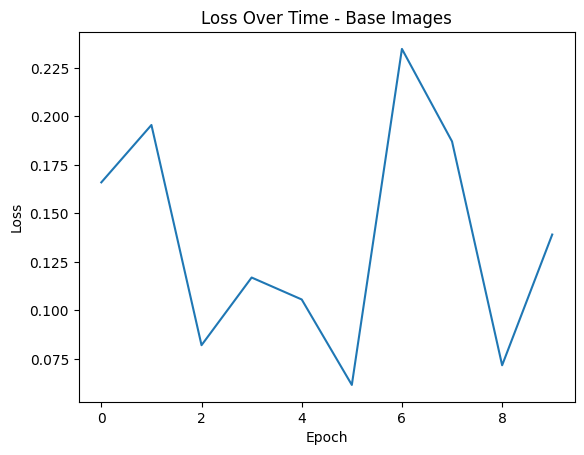

In [130]:
import pandas as pd

model = DefectIdentificationNetwork()


if os.path.exists('models/base-model.pth'):
    print(f'Using saved model.')
    model.load_state_dict(torch.load('models/base-model.pth'))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Type of device used for training: {device}')
model = model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

num_epochs = 10
model.train() # Put network into training mode, where neural network weights can change

loss_arr = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_dataloader)}], Loss: {loss.item()}')
        
        torch.save(model.state_dict(), 'models/base-model.pth')
        


    avg_loss = total_loss / len(train_dataloader)
    loss_arr.append(avg_loss)
    print(f'Average Loss after epoch {epoch + 1}: {avg_loss}')

loss_tracker_base_path = "reports/loss_tracker/loss_per_epoch_batch_base.csv"

base_loss_tracker = None

if os.path.exists(loss_tracker_base_path):
    base_loss_tracker = pd.read_csv(loss_tracker_base_path)
else:
    base_loss_tracker = pd.DataFrame({"Loss" : []})

## loss tracker example format - "Loss" : [0.5, 0.3, 0.2]
average_loss = sum(loss_arr) / num_epochs
base_loss_tracker = pd.concat([base_loss_tracker, pd.DataFrame({"Loss": [average_loss]})], ignore_index=True)

base_loss_tracker.to_csv(loss_tracker_base_path, index=False)

plt.plot(loss_arr)
plt.title('Loss Over Time - Base Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Base-loss.png')

# Validation Step: Model Evaluation and Performance Reporting

## Functionality Overview
This script evaluates the trained `DefectIdentificationNetwork` on a test dataset, generates predictions, calculates performance metrics (accuracy and misclassification rate), and saves classification results and confusion matrix data to files.

---

## Code Details

### **1. Dataset and DataLoader Setup**
- **Transforms**:
  - Applies a set of transformations to the test dataset:
    - Resize images to `(224, 224)`.
    - Randomly rotate images by up to 15 degrees.
    - Randomly horizontally flip images with a 90% probability.
    - Normalize using ImageNet mean and standard deviation values.

- **Test Dataset and DataLoader**:
  - Loads the `CustomBottleDataset` for the test set using:
    - `data_directory='bottle/test'`.
    - `labels_path='test_annotations.json'`.
    - Transformation pipeline (`T`).
  - Wraps the dataset in a PyTorch `DataLoader` with a batch size of 5 and no shuffling.

---

### **2. Model Initialization**
- **Loading Trained Model**:
  - Loads the weights of the previously trained model from `models/base-model.pth`.
  - Moves the model to the selected device (MPS for Apple Silicon if available, otherwise CPU).
  - Puts the model in evaluation mode using `model.eval()`.

- **Label Mapping**:
  - Uses a predefined mapping for labels:
    ```python
    label_mapping = {'good': 0, 'broken-small': 1, 'broken-large': 2, 'contamination': 3}
    ```
  - Creates a reverse mapping (`reverse_label_mapping`) for converting integer labels back to their string representations.

---

### **3. Evaluation Loop**
- **Batch Processing**:
  - For each batch in the test DataLoader:
    1. Performs a forward pass to compute predictions.
    2. Uses `torch.max` to extract the predicted class for each image.
    3. Appends predictions and ground truth labels to lists for later metric computation.

- **Logging Results**:
  - For each image in the batch:
    - Logs the filename, true label, and predicted label to a text file (`classification_results.txt`).
    - Adds classification results to a confusion matrix mapping structure for later DataFrame creation.
    - Visualizes incorrectly classified images by reversing normalization and displaying the image using `matplotlib`.

---

### **4. Metrics Calculation**
- **Accuracy**:
  - Computes the classification accuracy using `sklearn.metrics.accuracy_score`:
    ```python
    accuracy = accuracy_score(groundtruth, predictions)
    print(f'Accuracy: {accuracy * 100}%')
    ```

- **Misclassification Rate**:
  - Constructs a DataFrame (`conf_df`) from the confusion matrix mapping.
  - Calculates the misclassification rate:
    ```python
    num_false = (conf_df['Result'] == False).sum()
    misclassification_rate = num_false / len(conf_df)
    print("Number of false classifications:", num_false)
    print("Misclassification rate: %", (misclassification_rate * 100))
    ```

---

### **5. Output Files**
- **Classification Results**:
  - `classification_results.txt`: Logs filenames, true labels, and predicted labels for each test image.

- **Confusion Matrix Data**:
  - `base_conf_matrix.csv`: Stores a detailed confusion matrix as a CSV with columns:
    - `Image`: Filename of the test image.
    - `Actual`: True label.
    - `Predicted`: Predicted label.
    - `Result`: Whether the prediction was correct (True/False).

- **Visualization**:
  - Displays incorrectly classified images with titles showing the filename, true label, and predicted label.

---


/var/folders/v4/d7x3sgjd0zs0jbb4ytx6w2gh0000gn/T/ipykernel_98743/3184302117.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/bas

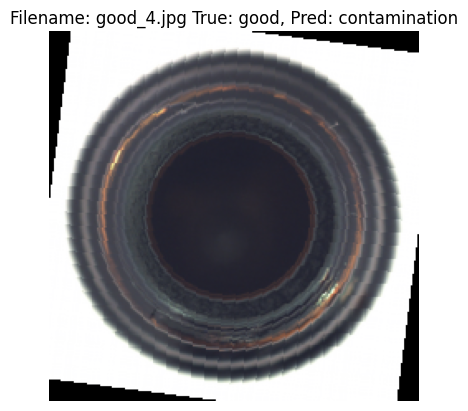

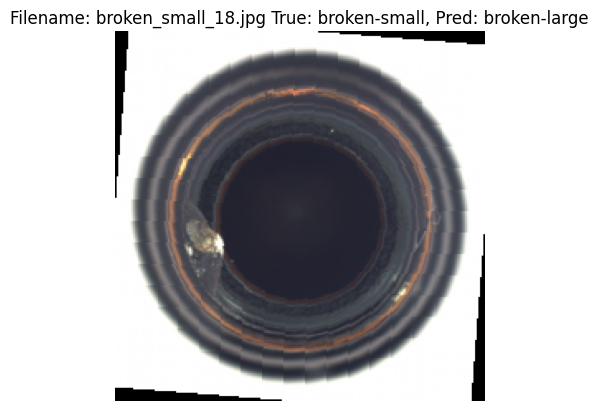

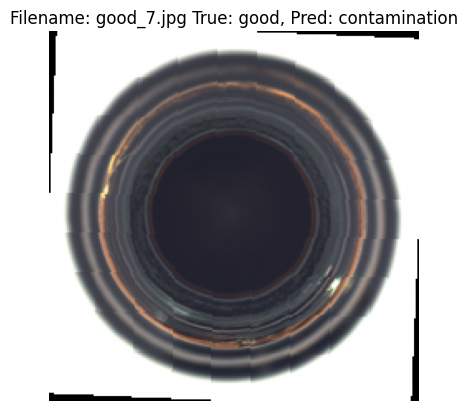

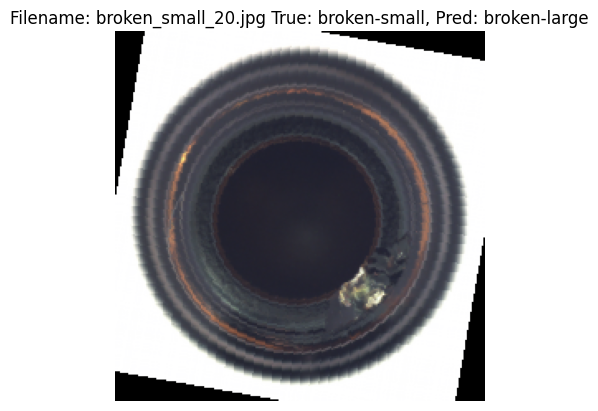

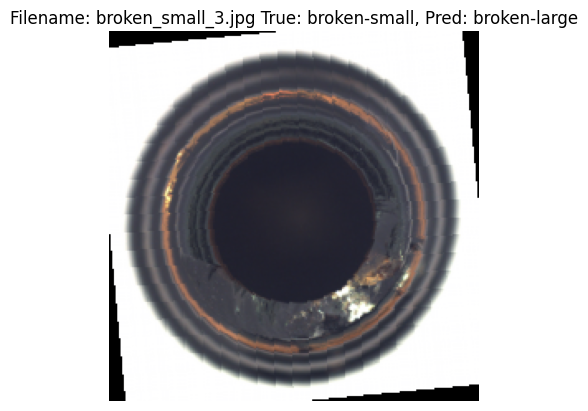

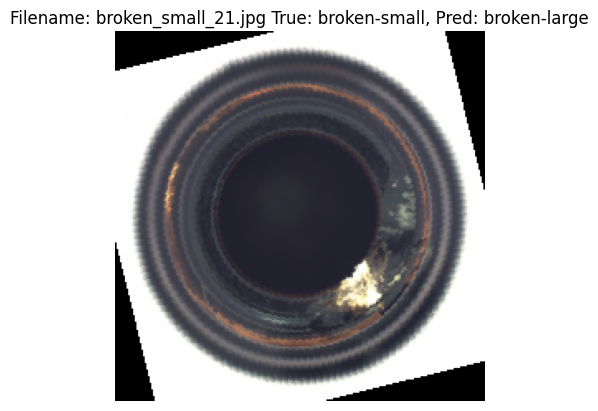

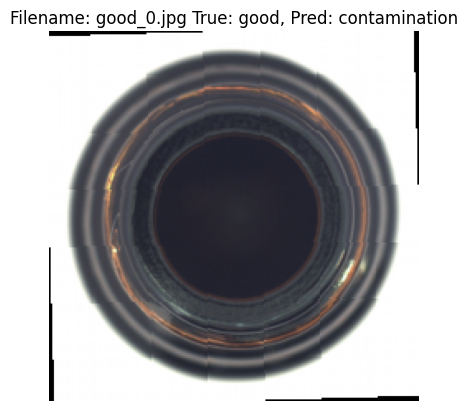

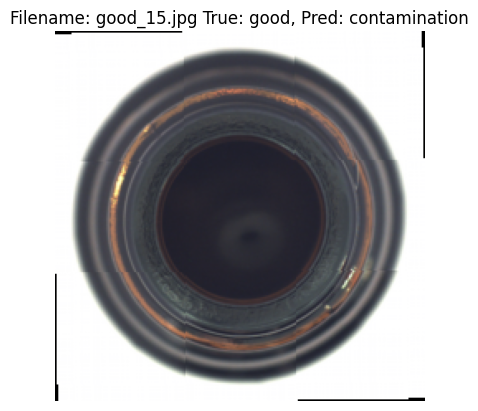

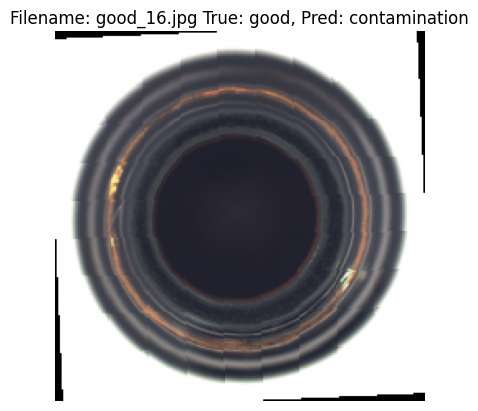

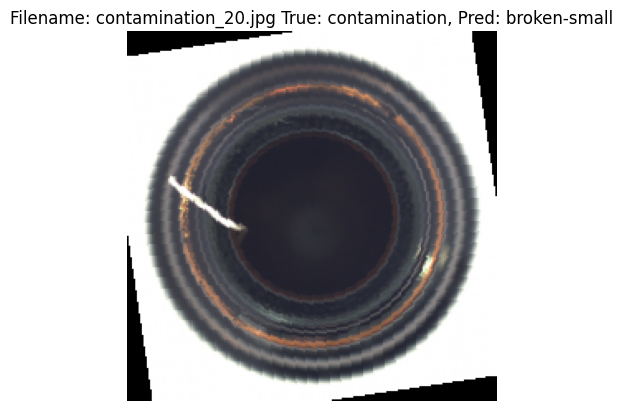

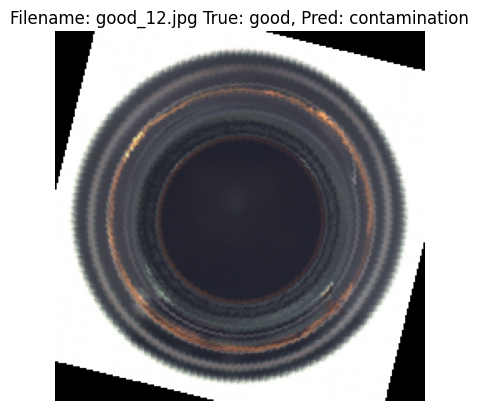

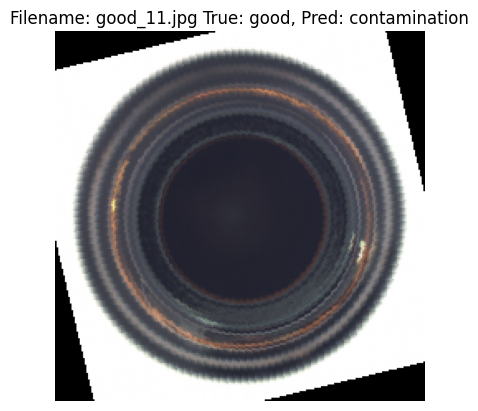

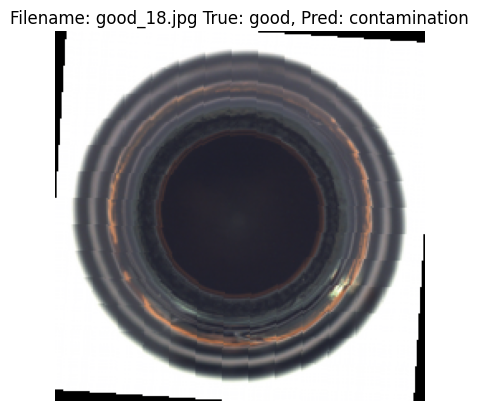

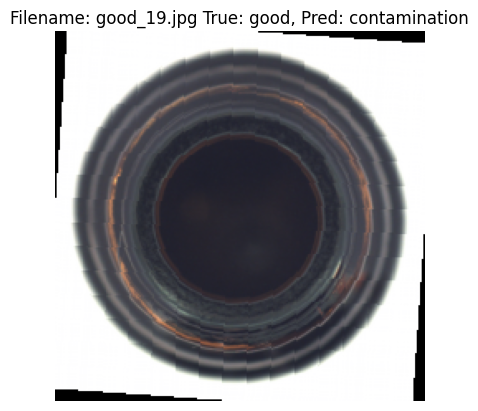

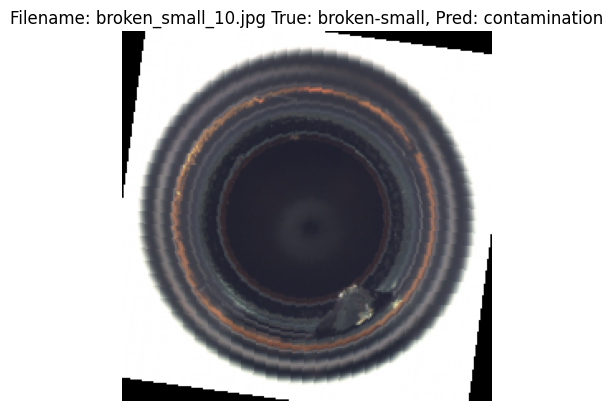

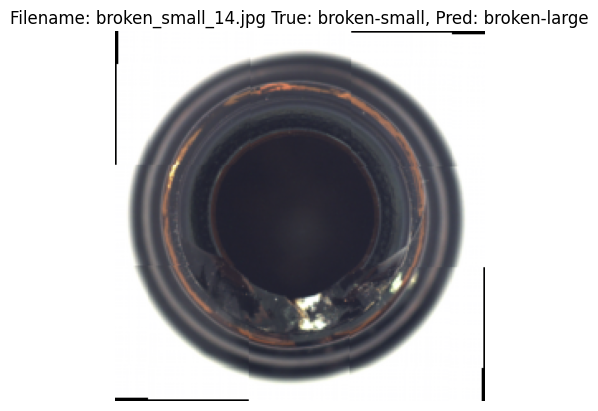

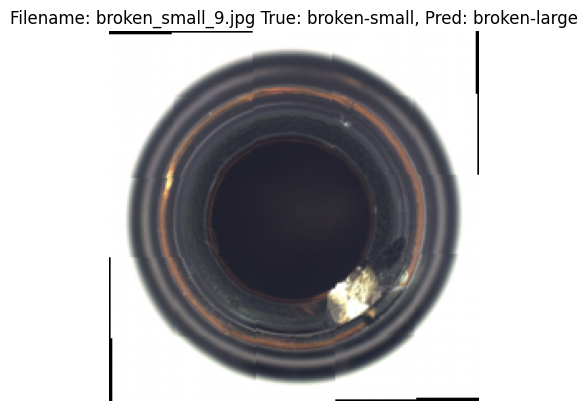

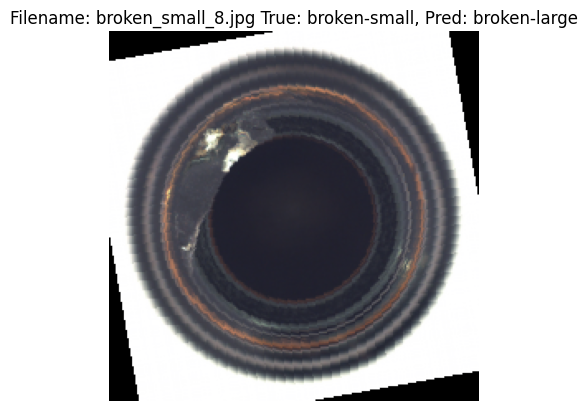

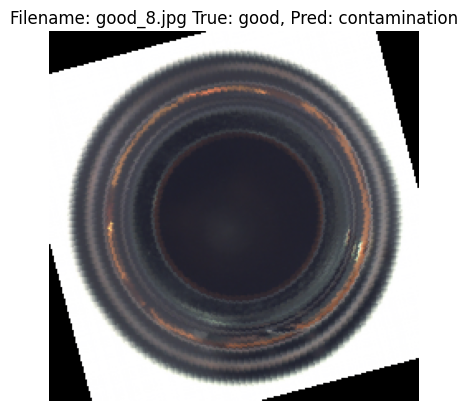

Accuracy: 77.10843373493977%
Number of false classifications: 19
Misclassification rate: % 22.89156626506024


In [131]:
from sklearn.metrics import accuracy_score
import cv2 
import pandas as pd

T = v2.Compose([
      v2.Resize(size=(224,224), antialias=True),
      v2.RandomRotation(degrees=15),
      v2.RandomHorizontalFlip(p=0.9),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = CustomBottleDataset(data_directory='bottle/test', labels_path='test_annotations.json', transform=T)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F


predictions = []
groundtruth = []

model = DefectIdentificationNetwork()

if not os.path.exists('models/base-model.pth'):
    print(f'Execute the previous cell to train the base model.')

model.load_state_dict(torch.load('models/base-model.pth', map_location=device))
model.to(device)

model.eval()  # Ensure the model is in evaluation mode


# Reverse the label mapping for easier interpretation
label_mapping = {'good': 0, 'broken-small': 1, 'broken-large': 2, 'contamination': 3}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

filenames = list(test_dataset.image_labels.keys())

global_idx = 0

conf_matrix_mapping = {
    "Image" : [],
    "Actual" : [],
    "Predicted" : [],
    "Result" : []
}

for batch_idx, data in enumerate(test_loader):
    images, labels = data
    if torch.mps.is_available():
        images = images.to('mps')
        labels = labels.to('mps')

    # Perform forward pass without disabling gradients
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    predictions.extend(predicted.cpu().numpy())
    groundtruth.extend(labels.cpu().numpy())

    for i in range(len(images)):
        image = images[i]
        true_label = labels[i].item()
        pred_label = predicted[i].item()

        # Write classification results to the file
        with open("classification_results.txt", "a") as log_file:
            log_file.write(
                f"Image: {filenames[global_idx]}, True: {reverse_label_mapping[true_label]}, Pred: {reverse_label_mapping[pred_label]}\n"
            )

        # Reverse normalization for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        image = image * std[:, None, None] + mean[:, None, None]

        # Plot if prediction is incorrect
        if pred_label != true_label:
            plt.imshow(image.cpu().permute(1, 2, 0).clip(0, 1).numpy())
            plt.title(f"Filename: {filenames[global_idx]} True: {reverse_label_mapping[true_label]}, Pred: {reverse_label_mapping[pred_label]}")
            plt.axis('off')
            plt.show()
        
        conf_matrix_mapping['Image'].append(filenames[global_idx])
        conf_matrix_mapping['Actual'].append(reverse_label_mapping[true_label])
        conf_matrix_mapping['Predicted'].append(reverse_label_mapping[pred_label])
        conf_matrix_mapping['Result'].append(pred_label == true_label)

        global_idx += 1  # Increment global index

# Calculate accuracy
accuracy = accuracy_score(groundtruth, predictions)
print(f'Accuracy: {accuracy * 100}%')

conf_df = pd.DataFrame(conf_matrix_mapping)

report_path = "reports/base_conf_matrix.csv"

conf_df.to_csv(report_path)

# Count the number of False results
num_false = (conf_df['Result'] == False).sum()

# Total number of rows
total = len(conf_df)

# Calculate misclassification rate
misclassification_rate = num_false / total

print("Number of false classifications:", num_false)
print("Misclassification rate: %", (misclassification_rate * 100))


# Preprocessing for Model Using Sharpened Images: Sharpening Images and Generating Annotations

## Functionality Overview
This script processes training and testing images by applying sharpening techniques using Sobel edge detection and overlaying the edges onto the original images. The processed images are saved to a designated directory, and annotation files for these sharpened images are generated.

---

## Code Details

### **1. Sharpening Images**
The function `sharpen_images(base_dir, new_dir)` performs the following steps:

#### **Input Parameters**:
- `base_dir`: Directory containing the original images to be processed.
- `new_dir`: Directory to save the sharpened images.

#### **Steps**:
1. **Ensure Output Directory**:
   - Creates the `new_dir` if it does not already exist.

2. **Iterate Through Images**:
   - Walks through all image files in the `base_dir`.

3. **Image Processing**:
   - Reads each image using OpenCV.
   - Converts the image to grayscale for edge detection.
   - Applies Sobel filtering in both \(x\)- and \(y\)-directions to detect edges.
   - Calculates the edge magnitude and normalizes it to the range [0, 255].
   - Converts the edge map to a 3-channel image for overlaying.
   - Overlays the edges onto the original image using weighted addition to produce a sharpened effect.

4. **Save Sharpened Images**:
   - Saves the processed image to `new_dir` with the same filename.

5. **Logging**:
   - Logs the total number of images successfully processed.

#### **Output**:
- Sharpened images saved to `new_dir`.

---

### **2. Generating Sharpened Image Annotations**
- **Purpose**:
  - Generates annotation files for the sharpened images in both the training and testing datasets.

- **Function Call**:
  - Uses the previously defined `create_json_labels` function to generate JSON files mapping filenames to labels:
    ```python
    create_json_labels('sharpened/train', 'bottle/sharpened/train_annotations.json')
    create_json_labels('sharpened/test', 'bottle/sharpened/test_annotations.json')
    ```

---

### **3. Directory Structure**
The code block works with the following directory hierarchy:
- **Input Directories**:
  - `bottle/train/`: Original training images.
  - `bottle/test/`: Original testing images.
- **Output Directories**:
  - `bottle/sharpened/train/`: Sharpened training images.
  - `bottle/sharpened/test/`: Sharpened testing images.

---



In [ ]:
## Sharpening images 

import cv2


## sharpening all training images and moving them to sharpened directory

def sharpen_images(base_dir, new_dir):
    # Ensure the output directory exists
    os.makedirs(new_dir, exist_ok=True)

    # Sobel kernel will be used for edge detection
    ct = 0  # Counter for processed images

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            base_image_path = os.path.join(root, file)

            if os.path.exists(base_image_path):
                # Load the original color image
                base_img = cv2.imread(base_image_path)
                if base_img is None:
                    print(f"Could not read the image at path: {base_image_path}")
                    continue

                # Convert the color image to grayscale for edge detection
                base_img_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)

                # Apply Sobel filtering to detect edges
                sobel_x = cv2.Sobel(base_img_gray, cv2.CV_64F, 1, 0, ksize=5)
                sobel_y = cv2.Sobel(base_img_gray, cv2.CV_64F, 0, 1, ksize=5)
                edges = cv2.magnitude(sobel_x, sobel_y)

                # Normalize edges to the range [0, 255] and convert to uint8
                edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

                # Convert edges to 3-channel format for overlay
                edges_3channel = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

                # Overlay the edges onto the original color image
                sharpened_color_img = cv2.addWeighted(base_img, 1, edges_3channel, 1.0, 0)

                # Save the sharpened image
                sharpened_img_path = os.path.join(new_dir, file)
                cv2.imwrite(sharpened_img_path, sharpened_color_img)
                print(f"Saved sharpened image to: {sharpened_img_path}")
                ct += 1
            else:
                print(f"Base image path does not exist: {base_image_path}")

    print(f"Sharpened {ct} images")


# Directories for training and testing data
base_training_directory = 'bottle/train/'
sharpened_training_directory = 'bottle/sharpened/train'

if not os.path.exists(sharpened_training_directory):
    sharpen_images(base_training_directory, sharpened_training_directory)
else:
    print('Skipping creating training images.')

base_test_directory = 'bottle/test/'
sharpened_test_directory = 'bottle/sharpened/test'

if not os.path.exists(sharpened_test_directory):
    sharpen_images(base_test_directory, sharpened_test_directory)
else:
    print('Skipping creating testing images.')


## create the annotation files for the sharpened images.
create_json_labels('sharpened/train', 'bottle/sharpened/train_annotations.json')            

## Create the annotations for the test dataset - good
create_json_labels('sharpened/test', 'bottle/sharpened/test_annotations.json')

Saved sharpened image to: bottle/sharpened/train/good_206.jpg
Saved sharpened image to: bottle/sharpened/train/contamination_4.jpg
Saved sharpened image to: bottle/sharpened/train/good_5.jpg
Saved sharpened image to: bottle/sharpened/train/good_158.jpg
Saved sharpened image to: bottle/sharpened/train/good_170.jpg
Saved sharpened image to: bottle/sharpened/train/good_63.jpg
Saved sharpened image to: bottle/sharpened/train/good_77.jpg
Saved sharpened image to: bottle/sharpened/train/good_164.jpg
Saved sharpened image to: bottle/sharpened/train/good_88.jpg
Saved sharpened image to: bottle/sharpened/train/broken_large_8.jpg
Saved sharpened image to: bottle/sharpened/train/broken_small_5.jpg
Saved sharpened image to: bottle/sharpened/train/broken_small_4.jpg
Saved sharpened image to: bottle/sharpened/train/broken_large_9.jpg
Saved sharpened image to: bottle/sharpened/train/good_89.jpg
Saved sharpened image to: bottle/sharpened/train/good_165.jpg
Saved sharpened image to: bottle/sharpened/tr

# Training Model for Sharpened Images: Training the Model on Sharpened Images

## Functionality Overview
This code block trains the `DefectIdentificationNetwork` on sharpened images using a similar workflow as the training on original images. It involves:
- Preparing a dataset and DataLoader for sharpened images.
- Setting up a training loop with logging and loss tracking.
- Saving the model and training metrics.

---

## Key Differences
1. **Dataset and DataLoader**:
   - Uses the sharpened images from `bottle/sharpened/train` with corresponding annotations in `bottle/sharpened/train_annotations.json`.
   - Applies data augmentation and normalization using a predefined transformation pipeline.

2. **Model Saving**:
   - Saves the trained model weights to `models/sharpened-model.pth`.

3. **Loss Tracker**:
   - Stores training loss in `loss_per_epoch_batch_sharpened.csv` for later analysis.

4. **Visualization**:
   - Plots the loss trend over epochs and saves it as `Sharpened-loss.png`.

---

## Workflow Summary

### 1. Dataset Preparation
- Creates a `CustomBottleDataset` for sharpened training images.
- Wraps the dataset in a DataLoader (`sharpened_train_dataloader`) with a batch size of 5.

### 2. Model Setup
- Loads `DefectIdentificationNetwork` and pretrained weights if available (`sharpened-model.pth`).
- Moves the model to the appropriate device (`mps` or `cpu`).

### 3. Training Loop
- Trains the model for 10 epochs, calculating and logging the loss every 10 batches.
- Saves the model state after each batch to ensure progress is not lost.

### 4. Loss Tracking
- Appends average loss per epoch to the loss tracker file (`loss_per_epoch_batch_sharpened.csv`).

### 5. Visualization
- Plots the loss trend for the training process, showing the model's performance improvement.

---

## Outputs

### 1. Model Weights:
- Saved to `models/sharpened-model.pth`.

### 2. Loss Tracker File:
- `loss_per_epoch_batch_sharpened.csv`:
  ```csv
  Loss
  0.512
  0.395
  0.287


Using saved model.
Type of device used for training: mps


/var/folders/v4/d7x3sgjd0zs0jbb4ytx6w2gh0000gn/T/ipykernel_98743/2562476472.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sharpened_m

Epoch [1/10], Step [10/54], Loss: 0.003471443895250559
Epoch [1/10], Step [20/54], Loss: 0.05210641026496887
Epoch [1/10], Step [30/54], Loss: 0.01604538783431053
Epoch [1/10], Step [40/54], Loss: 0.029340337961912155
Epoch [1/10], Step [50/54], Loss: 0.5955489873886108
Average Loss after epoch 1: 0.21731504412255837
Epoch [2/10], Step [10/54], Loss: 0.003987263888120651
Epoch [2/10], Step [20/54], Loss: 0.10268616676330566
Epoch [2/10], Step [30/54], Loss: 0.013473421335220337
Epoch [2/10], Step [40/54], Loss: 0.01574789546430111
Epoch [2/10], Step [50/54], Loss: 0.007403192110359669
Average Loss after epoch 2: 0.032714367723437374
Epoch [3/10], Step [10/54], Loss: 0.06604593992233276
Epoch [3/10], Step [20/54], Loss: 0.010262705385684967
Epoch [3/10], Step [30/54], Loss: 0.013405436649918556
Epoch [3/10], Step [40/54], Loss: 0.0043309880420565605
Epoch [3/10], Step [50/54], Loss: 0.051868993788957596
Average Loss after epoch 3: 0.1969598343604486
Epoch [4/10], Step [10/54], Loss: 0.0

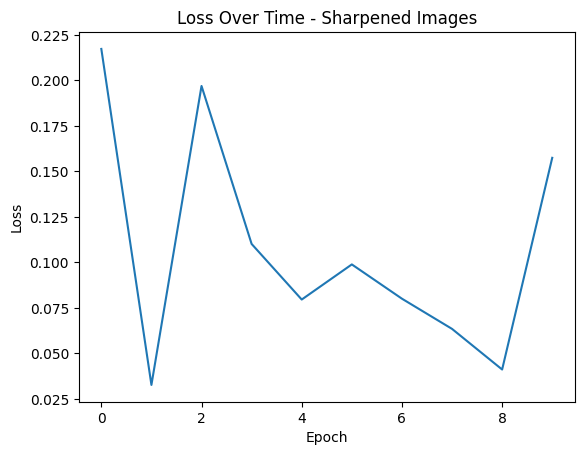

In [132]:
## train the model on the sharpened images

T = v2.Compose([
      v2.Resize(size=(224,224), antialias=True),
      v2.RandomRotation(degrees=45),
      v2.RandomHorizontalFlip(),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

sharpened_train_dataset = CustomBottleDataset(data_directory='bottle/sharpened/train', labels_path='bottle/sharpened/train_annotations.json', transform=T)
sharpened_train_dataloader = DataLoader(sharpened_train_dataset, batch_size=5, shuffle=True)


model = DefectIdentificationNetwork()

sharpened_model_path = 'models/sharpened-model.pth'

if os.path.exists(sharpened_model_path):
    print(f'Using saved model.')
    model.load_state_dict(torch.load(sharpened_model_path))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Type of device used for training: {device}')
model = model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

num_epochs = 10
model.train() # Put network into training mode, where neural network weights can change

loss_arr = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (images, labels) in enumerate(sharpened_train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_dataloader)}], Loss: {loss.item()}')
        
        torch.save(model.state_dict(), sharpened_model_path)


    avg_loss = total_loss / len(train_dataloader)
    loss_arr.append(avg_loss)
    print(f'Average Loss after epoch {epoch + 1}: {avg_loss}')

loss_tracker_base_path = "reports/loss_tracker/loss_per_epoch_batch_sharpened.csv"

sharpened_loss_tracker = None

if os.path.exists(loss_tracker_base_path):
    sharpened_loss_tracker = pd.read_csv(loss_tracker_base_path)
else:
    sharpened_loss_tracker = pd.DataFrame({"Loss" : []})

## loss tracker example format - "Loss" : [0.5, 0.3, 0.2]
average_loss = sum(loss_arr) / num_epochs
sharpened_loss_tracker = pd.concat([sharpened_loss_tracker, pd.DataFrame({"Loss": [average_loss]})], ignore_index=True)

sharpened_loss_tracker.to_csv(loss_tracker_base_path, index=False)

plt.plot(loss_arr)
plt.title('Loss Over Time - Sharpened Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Sharpened-loss.png')

# Validation Step for Model Using Sharpened Images: Evaluation on Sharpened Test Images

## Functionality Overview
This code block evaluates the `DefectIdentificationNetwork` on sharpened test images using a similar workflow as the evaluation on original test images. It involves:
- Loading the sharpened test dataset.
- Making predictions and logging results.
- Calculating accuracy and misclassification rate.
- Saving results and metrics for further analysis.

---

## Key Differences
1. **Dataset and DataLoader**:
   - Evaluates on sharpened images from `bottle/sharpened/test` with annotations in `bottle/sharpened/test_annotations.json`.

2. **Model Weights**:
   - Loads weights from `sharpened-model.pth`.

3. **Confusion Matrix File**:
   - Saves classification results to `reports/sharpened_conf_matrix.csv`.

4. **Visualization**:
   - Displays misclassified sharpened images with true and predicted labels.

---

## Outputs

### 1. Accuracy and Misclassification Rate:
- Prints overall accuracy and the percentage of misclassified images:
  ```plaintext
  Accuracy: 93.5%
  Number of false classifications: 10
  Misclassification rate: % 6.5


/var/folders/v4/d7x3sgjd0zs0jbb4ytx6w2gh0000gn/T/ipykernel_98743/127485768.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sharpened_mo

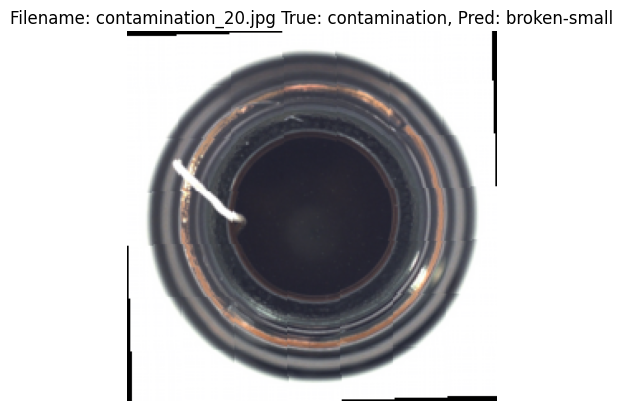

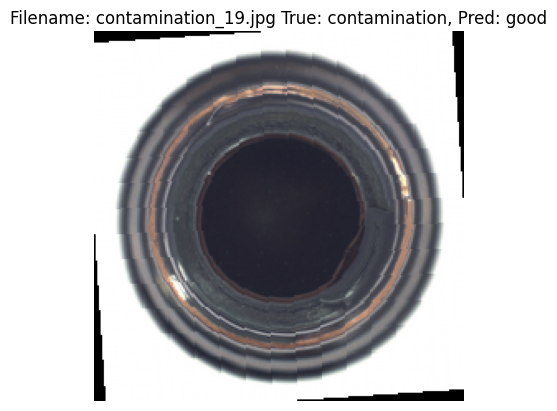

Accuracy: 97.59036144578313%
Number of false classifications: 2
Misclassification rate: % 2.4096385542168677


In [133]:
from sklearn.metrics import accuracy_score

T = v2.Compose([
      v2.Resize(size=(224,224), antialias=True),
      v2.RandomRotation(degrees=15),
      v2.RandomHorizontalFlip(p=0.9),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

sharpened_test_dataset = CustomBottleDataset(data_directory='bottle/sharpened/test', labels_path='bottle/sharpened/test_annotations.json', transform=T)
sharpened_test_loader = DataLoader(sharpened_test_dataset, batch_size=5, shuffle=False)

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import pandas as pd


predictions = []
groundtruth = []

model = DefectIdentificationNetwork()

model.load_state_dict(torch.load(sharpened_model_path, map_location=device))
model.to(device)

model.eval()  # Ensure the model is in evaluation mode


# Reverse the label mapping for easier interpretation
label_mapping = {'good': 0, 'broken-small': 1, 'broken-large': 2, 'contamination': 3}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

filenames = list(sharpened_test_dataset.image_labels.keys())

global_idx = 0

conf_matrix_mapping = {
    "Image" : [],
    "Actual" : [],
    "Predicted" : [],
    "Result" : []
}

for batch_idx, data in enumerate(sharpened_test_loader):
    images, labels = data
    if torch.mps.is_available():
        images = images.to('mps')
        labels = labels.to('mps')

    # Perform forward pass without disabling gradients
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    predictions.extend(predicted.cpu().numpy())
    groundtruth.extend(labels.cpu().numpy())

    for i in range(len(images)):
        image = images[i]
        true_label = labels[i].item()
        pred_label = predicted[i].item()

        # Write classification results to the file
        with open("classification_results.txt", "a") as log_file:
            log_file.write(
                f"Image: {filenames[global_idx]}, True: {reverse_label_mapping[true_label]}, Pred: {reverse_label_mapping[pred_label]}\n"
            )

        # Reverse normalization for visualization
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        image = image * std[:, None, None] + mean[:, None, None]

        # Plot if prediction is incorrect
        if pred_label != true_label:

            plt.imshow(image.cpu().permute(1, 2, 0).clip(0, 1).numpy())
            plt.title(f"Filename: {filenames[global_idx]} True: {reverse_label_mapping[true_label]}, Pred: {reverse_label_mapping[pred_label]}")
            plt.axis('off')
            plt.show()
       
        conf_matrix_mapping['Image'].append(filenames[global_idx])
        conf_matrix_mapping['Actual'].append(reverse_label_mapping[true_label])
        conf_matrix_mapping['Predicted'].append(reverse_label_mapping[pred_label])
        conf_matrix_mapping['Result'].append(pred_label == true_label)

        global_idx += 1  # Increment global index

# Calculate accuracy
accuracy = accuracy_score(groundtruth, predictions)
print(f'Accuracy: {accuracy * 100}%')

conf_df = pd.DataFrame(conf_matrix_mapping)

report_path = "reports/sharpened_conf_matrix.csv"

conf_df.to_csv(report_path)

# Count the number of False results
num_false = (conf_df['Result'] == False).sum()

# Total number of rows
total = len(conf_df)

# Calculate misclassification rate
misclassification_rate = num_false / total

print("Number of false classifications:", num_false)
print("Misclassification rate: %", (misclassification_rate * 100))

# Analyzing the Base Model: Visualizing Loss Over Epochs

## Functionality Overview
This code block reads loss data from a CSV file, processes it, and visualizes the loss values over epochs. The loss is plotted as a line graph to provide insights into the base model's training performance.

---

## Key Steps

### **1. Check for CSV File**
- **File Path**:
  - The loss data is read from `reports/loss_tracker/loss_per_epoch_batch_base.csv`.
- **File Existence Check**:
  - If the file does not exist, a message is printed:
    ```python
    if not os.path.exists(base_loss_data_path):
        print(f'Required CSV file does not exist yet.')
    ```

---

### **2. Read Loss Data**
- The script reads the CSV file using `pandas`:
  ```python
  base_loss_data = pd.read_csv(base_loss_data_path)


2


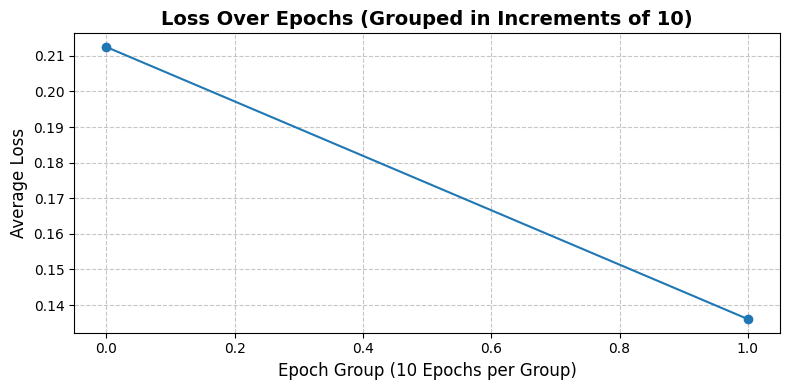

In [136]:
base_loss_data_path = "reports/loss_tracker/loss_per_epoch_batch_base.csv"

if not os.path.exists(base_loss_data_path):
    print(f'Required CSV file does not exist yet.')

base_loss_data = pd.read_csv(base_loss_data_path)

print(len(base_loss_data))
base_loss_data["Index"] = base_loss_data.index

plt.figure(figsize=(8, 4))
plt.plot(base_loss_data["Loss"], marker='o')
plt.title("Loss Over Epochs (Grouped in Increments of 10)", fontsize=14, weight='bold')
plt.xlabel("Epoch Group (10 Epochs per Group)", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Code Summary: Visualizing Loss Over Epochs for Sharpened Images

## Functionality Overview
This code block visualizes the loss values over epochs for the model trained on sharpened images. It reads the loss data from a CSV file and plots it as a line graph.

---

## Key Steps

### **1. Check for CSV File**
- **File Path**:
  - Loss data is read from `reports/loss_tracker/loss_per_epoch_batch_sharpened.csv`.
- **File Existence Check**:
  - Ensures the file exists before proceeding.

### **2. Read and Process Data**
- Reads the CSV file into a pandas DataFrame.
- Plots the `Loss` column, representing the loss for each epoch.

### **3. Plot the Loss**
- **Graph Details**:
  - X-Axis: Epochs.
  - Y-Axis: Average Loss.
  - Title: "Loss Over Epochs (Grouped in Increments of 10) - Sharpened Images".
- **Visualization**:
  - Displays a line graph with markers and a grid for clarity.

---



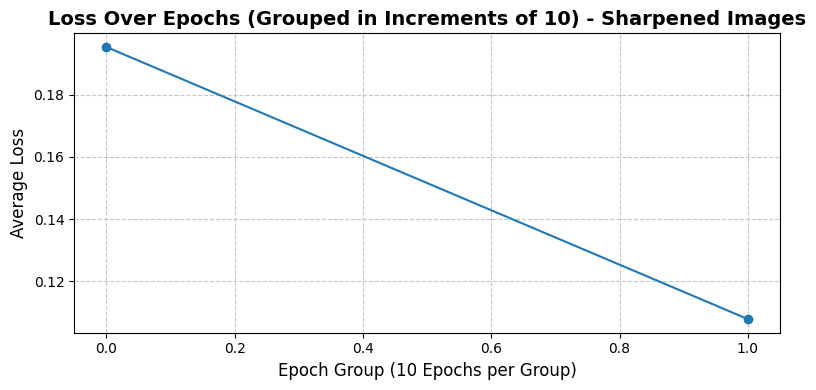

In [137]:
sharpened_loss_data_path = "reports/loss_tracker/loss_per_epoch_batch_sharpened.csv"

if not os.path.exists(sharpened_loss_data_path):
    print(f'Required CSV file does not exist yet.')

sharpened_loss_data = pd.read_csv(sharpened_loss_data_path)

sharpened_loss_data["Index"] = sharpened_loss_data.index

plt.figure(figsize=(8, 4))
plt.plot(sharpened_loss_data["Loss"], marker='o')
plt.title("Loss Over Epochs (Grouped in Increments of 10) - Sharpened Images", fontsize=14, weight='bold')
plt.xlabel("Epoch Group (10 Epochs per Group)", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [138]:
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

conf_base_path = "reports/base_conf_matrix.csv"
conf_sharpened_path = "reports/sharpened_conf_matrix.csv"

if not os.path.exists(conf_base_path) or not os.path.exists(conf_sharpened_path):
    print(f'Required CSV files have not been generated')

conf_base_df = pd.read_csv(conf_base_path)
conf_sharpened_df = pd.read_csv(conf_sharpened_path)

actual_base = conf_base_df["Actual"]
predicted_base = conf_base_df["Predicted"]

precision_base = precision_score(actual_base, predicted_base, average="weighted", zero_division=0)
recall_base = recall_score(actual_base, predicted_base, average="weighted", zero_division=0)
f1_base = f1_score(actual_base, predicted_base, average="weighted", zero_division=0)

base_model_metrics = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score"],
    "Value": [precision_base, recall_base, f1_base]
})

base_model_metrics



Metric     Value
0  Precision  0.830079
1     Recall  0.771084
2   F1 Score  0.760929

In [139]:
conf_sharpened_df = pd.read_csv(conf_sharpened_path)

actual_sharp = conf_sharpened_df["Actual"]
predicted_sharp = conf_sharpened_df["Predicted"]

precision_sharp = precision_score(actual_sharp, predicted_sharp, average="weighted", zero_division=0)
recall_sharp = recall_score(actual_sharp, predicted_sharp, average="weighted", zero_division=0)
f1_sharp = f1_score(actual_sharp, predicted_sharp, average="weighted", zero_division=0)

sharp_model_metrics = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score"],
    "Value": [precision_sharp, recall_sharp, f1_sharp]
})

sharp_model_metrics

Metric     Value
0  Precision  0.977001
1     Recall  0.975904
2   F1 Score  0.975582

In [140]:
comparison_metrics = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score"],
    "Base Model": [precision_base, recall_base, f1_base],
    "Sharpened Model": [precision_sharp, recall_sharp, f1_sharp]
})

comparison_metrics

Metric  Base Model  Sharpened Model
0  Precision    0.830079         0.977001
1     Recall    0.771084         0.975904
2   F1 Score    0.760929         0.975582